In [5]:
from imports.TactileBag import TactileBag

tbag = TactileBag('../data/bags/data2/')
tbag.events

dask.array<array, shape=(187519868, 4), dtype=int64, chunksize=(4153282, 4), chunktype=numpy.ndarray>

In [1]:
from imports.ExtractContactCases import ExtractContactCases

ex = ExtractContactCases(
    '../data/bags/data2/', 
    '../data/bags/data2/extractions/online',
    )
ex.list_of_rotations

[[0, 0, 0],
 [0.016507624989807086, 0.00566707481709966, 0],
 [0.03301524997961417, 0.01133414963419932, 0],
 [0.04952287496942126, 0.017001224451298983, 0],
 [0.06603049995922834, 0.02266829926839864, 0],
 [0.08253812494903542, 0.0283353740854983, 0],
 [0.09904574993884252, 0.034002448902597966, 0],
 [0.1155533749286496, 0.03966952371969762, 0],
 [0.13206099991845668, 0.04533659853679728, 0],
 [0.14856862490826378, 0.05100367335389694, 0],
 [0.16507624989807085, 0.0566707481709966, 0],
 [0.013773100149832318, 0.01072003414404066, 0],
 [0.027546200299664637, 0.02144006828808132, 0],
 [0.04131930044949696, 0.03216010243212198, 0],
 [0.05509240059932927, 0.04288013657616264, 0],
 [0.06886550074916159, 0.053600170720203295, 0],
 [0.08263860089899391, 0.06432020486424396, 0],
 [0.09641170104882622, 0.07504023900828462, 0],
 [0.11018480119865855, 0.08576027315232528, 0],
 [0.12395790134849086, 0.09648030729636593, 0],
 [0.13773100149832318, 0.10720034144040659, 0],
 [0.009546046196954917, 0

In [2]:
ex.parse_bag()

extracting contact timestamps:   0%|          | 0/508732 [00:00<?, ?it/s]

In [3]:
import numpy as np

Delta_t = np.linspace(0.04, 0.2, 6)*1e9
Margin = -0.2e9 + Delta_t

Delta_t/1e9, Margin/1e9

(array([0.04 , 0.072, 0.104, 0.136, 0.168, 0.2  ]),
 array([-0.16 , -0.128, -0.096, -0.064, -0.032,  0.   ]))

In [4]:
import dask.array as da
downsample = 2

dist_from_center = lambda x, y: da.sqrt((x - ex.center[0])**2 + (y - ex.center[1])**2)

in_circle = dist_from_center(ex.events[:, 0], ex.events[:, 1]) < ex.circle_rad
idx_downsample = np.random.choice(
    [0, 1], 
    ex.events.shape[0], 
    p=np.array([downsample-1, 1]) / downsample
    ).astype(bool)

in_circle = in_circle & idx_downsample
events = ex.events[in_circle].compute_chunk_sizes()
events

dask.array<getitem_variadic, shape=(79206937, 4), dtype=int64, chunksize=(1797014, 4), chunktype=numpy.ndarray>

  0%|          | 0/6 [00:00<?, ?it/s]

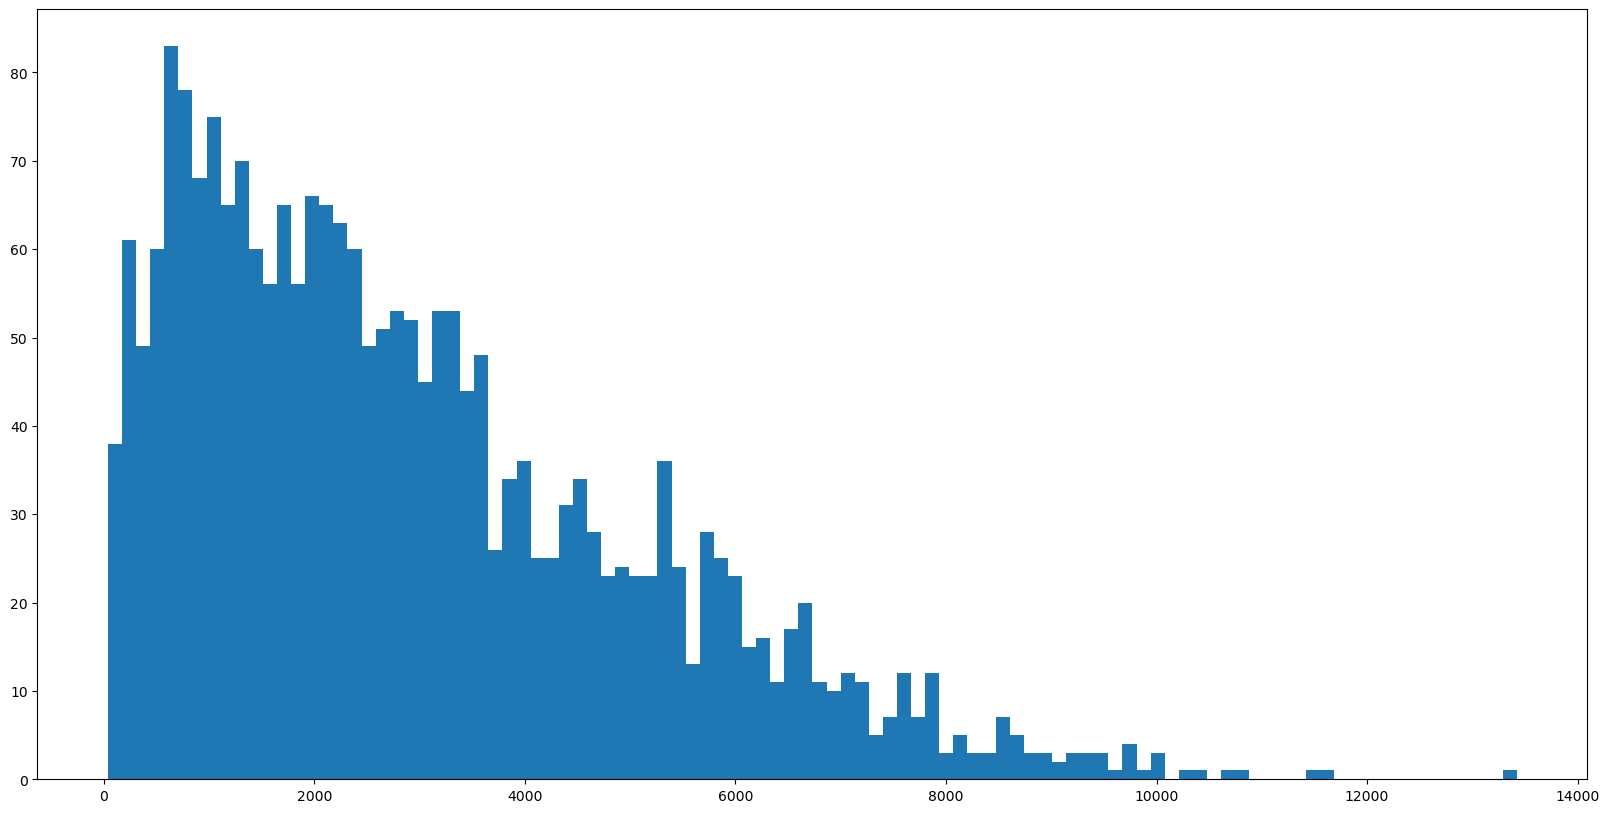

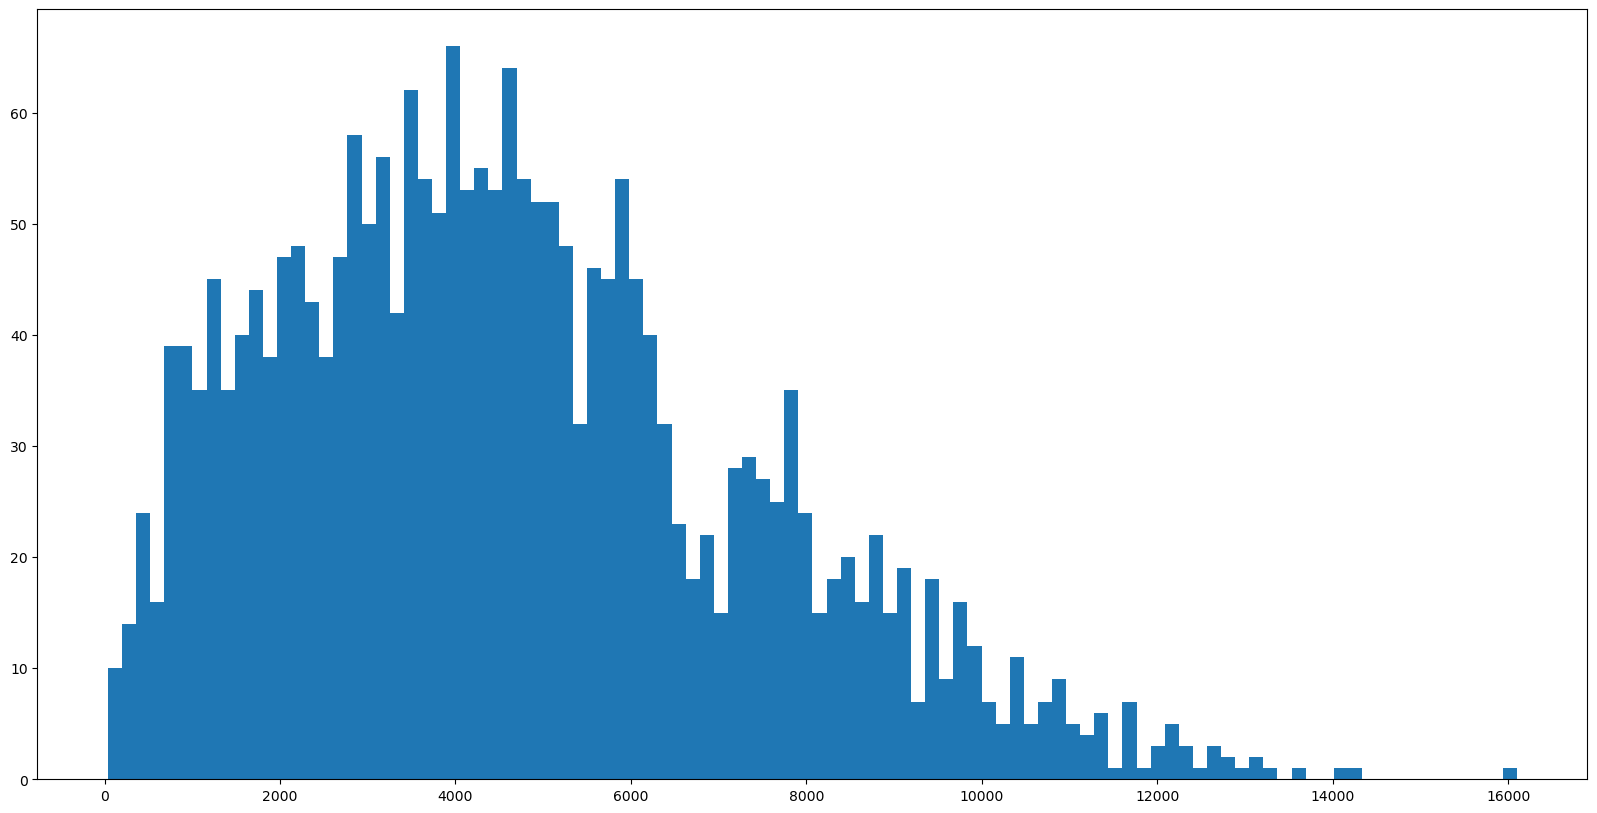

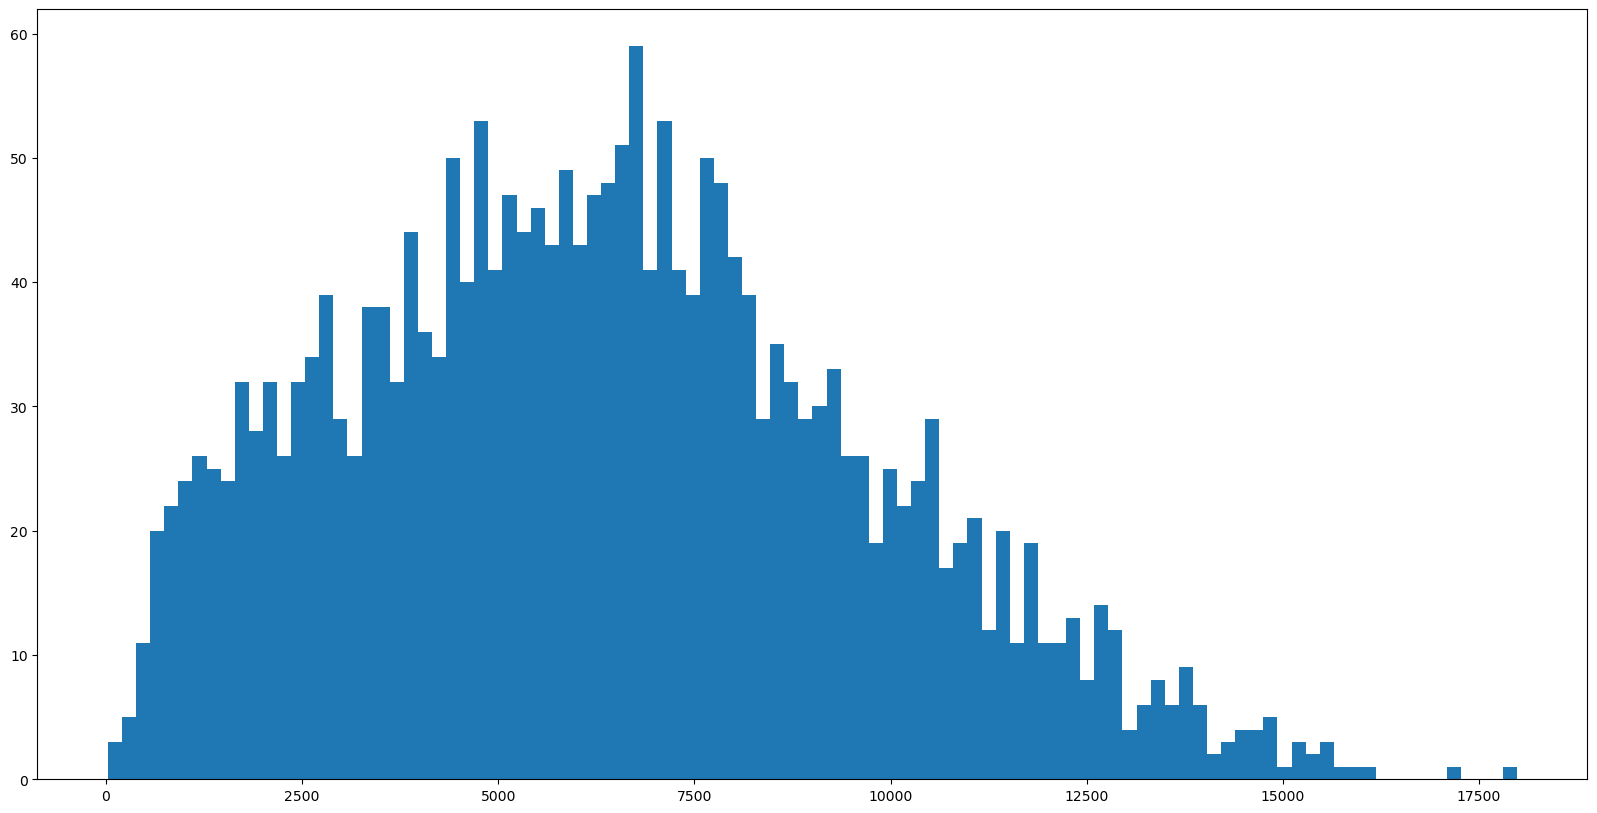

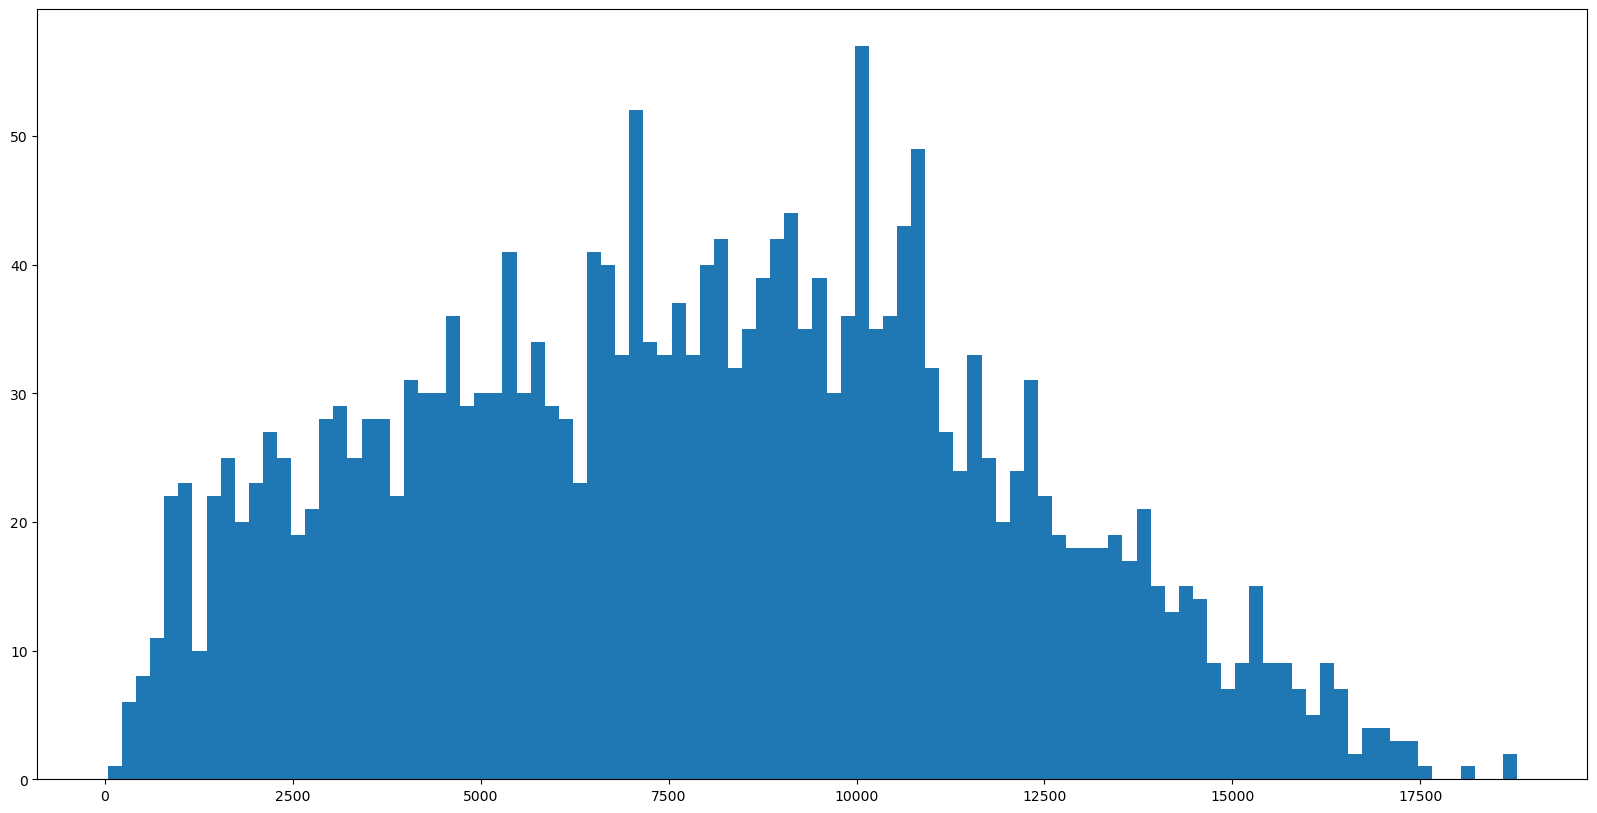

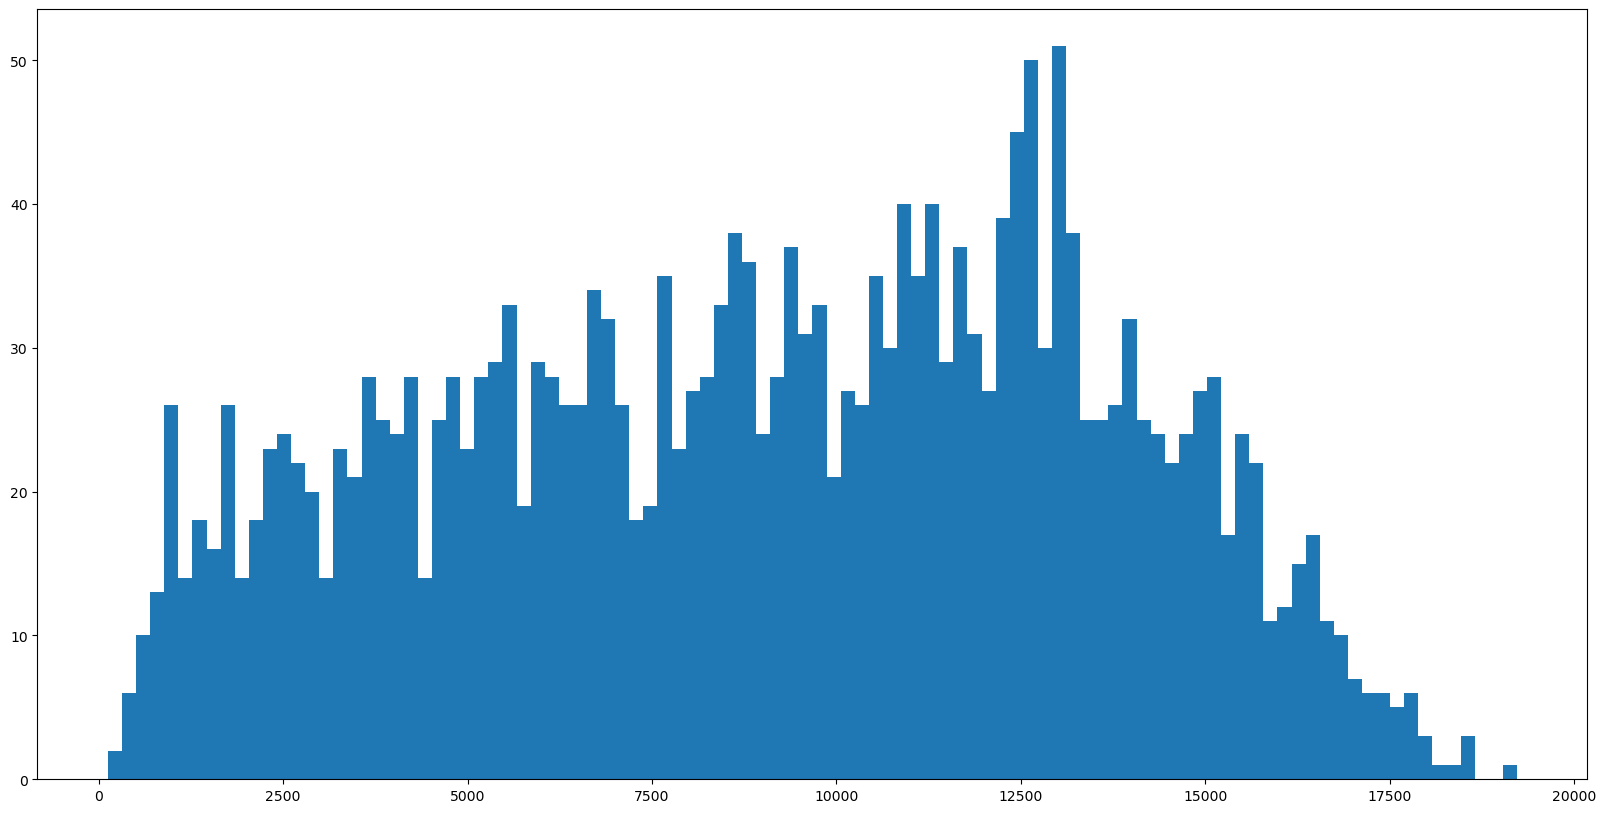

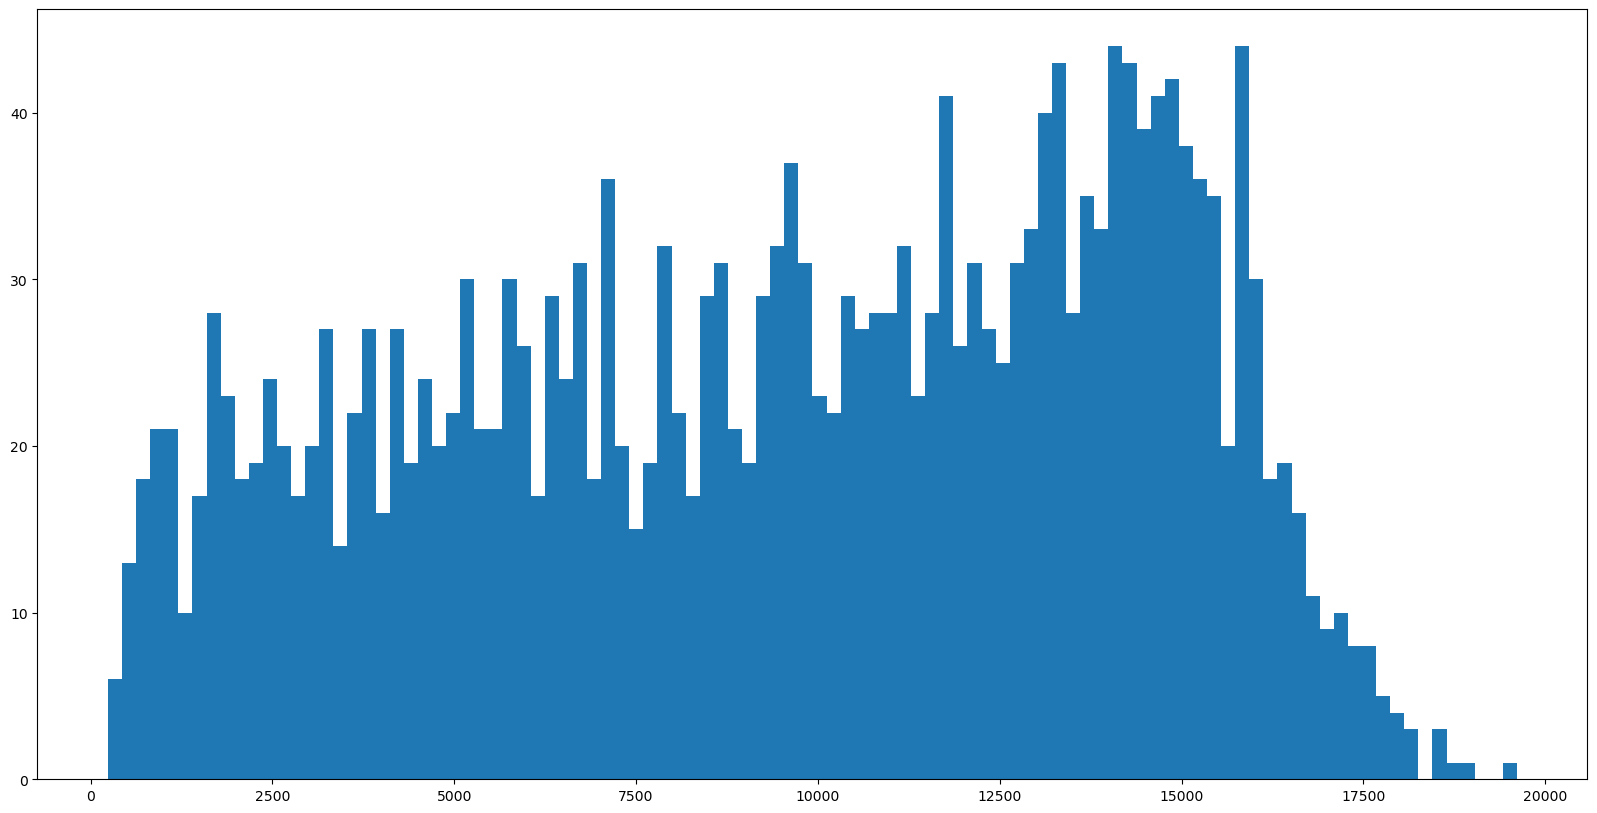

In [5]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

init_cases_ts = da.array(ex.cases_ts)[:, 0]
n_events_per_case = []
ts = events[:, 2]

label_contact_case = []
init, end = [], []

for dt, margin in zip(tqdm(Delta_t), Margin):
    init_ev_array_idx = da.searchsorted(ts, init_cases_ts + margin).compute()
    fin_ev_array_idx = da.searchsorted(ts, init_cases_ts + dt).compute()
    init.append(init_ev_array_idx), end.append(fin_ev_array_idx)
    n_events_per_case.append(fin_ev_array_idx - init_ev_array_idx)
    plt.figure(figsize=(20, 10))
    plt.hist(n_events_per_case[-1], bins=100)


In [6]:
from itertools import chain, cycle

iterator = \
tqdm(
    enumerate(
        zip(
            cycle(ex.cases), 
            chain(*init), 
            chain(*end)
        )
    ),
total=len(ex.cases)*len(Delta_t)
)

samples = {}

for j, (case, i, e) in (iterator):
    samples[f'sample_{j+1}'] = {
        'events': events[i:e+1].compute().tolist(),
        'case': case
        }

  0%|          | 0/13752 [00:00<?, ?it/s]

In [2]:
import json

with open('../data/extractions/online/val/raw/contact_cases.json', 'r') as f:
    contact_cases = json.load(f)

contact_cases.__len__()

1719

In [3]:
with open('../data/bags/data2/extractions/online/samples.json', 'r') as f:
    samples = json.load(f)

samples.__len__()

13752

In [20]:
pip install pyyaml==5.3.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp38-cp38-linux_x86_64.whl size=573588 sha256=9a58998c3403fafadca69fbc836b5c2c4d8237dc10b13a98a158e31bbcc3fd73
  Stored in directory: /home/hussain/.cache/pip/wheels/13/dd/fd/9c91afde698cd4ace1d2e6fa7a5bf31dd152178c2e04613126
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bagpy 0.5 requires jinja2<3.1, but you have jinja2 3.1.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [21]:
import hdfdict
hdfdict.dump(samples, '../data/bags/data2/extractions/online/samples.h5')

ContextualVersionConflict: (PyYAML 6.0 (/home/hussain/miniconda3/envs/tactile/lib/python3.8/site-packages), Requirement.parse('pyyaml<6.0,>=5.1'), {'hdfdict'})

In [23]:
import h5py
from tqdm.auto import tqdm
#write samples to a h5 file
with h5py.File('../data/extractions/online/val/raw/samples_events.h5', 'w') as f:
    for k, v in tqdm(samples.items()):
        f.create_dataset(k, data=v['events'])

with h5py.File('../data/extractions/online/val/raw/samples_case.h5', 'w') as f:
    for k, v in tqdm(samples.items()):
        f.create_dataset(k, data=v['case'])


  0%|          | 0/13752 [00:00<?, ?it/s]

  0%|          | 0/13752 [00:00<?, ?it/s]

In [24]:
h5py.File('../data/extractions/online/val/raw/samples.h5', 'r').keys().__len__()

13752

In [8]:
import json
with open('../data/bags/data2/extractions/online/samples.json', 'w') as f:
    json.dump(samples, f)

In [69]:
len(samples)

13752

In [71]:
len(samples)

13752

In [ ]:
sample_idx = h5py.File('../data/extractions/online/')

In [26]:
def _samples(s_idx):
    out = {
        'events': h5py.File('../data/extractions/online/val/raw/samples_events.h5', 'r')[s_idx][:],
        'case': h5py.File('../data/extractions/online/val/raw/samples_case.h5', 'r')[s_idx][()]
    }
    return out

In [27]:
_samples('sample_1')

{'events': array([[                244,                  77, 1672235491607966634,
                           0],
        [                187,                 113, 1672235491612072634,
                           1],
        [                193,                  51, 1672235491612222634,
                           0],
        ...,
        [                178,                 102, 1672235491807028634,
                           0],
        [                180,                 104, 1672235491807070634,
                           0],
        [                149,                 135, 1672235491807107634,
                           0]]),
 'case': 1}

In [70]:
from sklearn.model_selection import train_test_split
if not ex.outdir.exists():
    ex.outdir.mkdir(parents=True)

with open(ex.outdir / 'extraction_params.json', 'w') as f:
    json.dump(ex.params, f, indent=4)

# with open(ex.outdir / 'samples.json', 'w') as f:
#     json.dump(samples, f, indent=4)

sample_idx = list(samples.keys())
cases = [str(samples[s_idx]['case']) for s_idx in sample_idx]

train_idx, val_test_idx = train_test_split(sample_idx, test_size=1-self.train_prop, random_state=0) #fixed across extractions

cases = [str(samples[s_idx]['case']) for s_idx in val_test_idx]
val_idx, test_idx = train_test_split(val_test_idx, test_size=0.5, random_state=0) #fixed across extractions

#print(len(train_idx), len(val_idx), len(test_idx))
subsets = zip(['train', 'val', 'test'], [train_idx, val_idx, test_idx])

if not ex.outdir.exists():
    ex.outdir.mkdir(parents=True)

with open(ex.outdir / 'extraction_params.json', 'w') as f:
    json.dump(ex.params, f, indent=4)

for sub_name, subset in subsets:
    if not (ex.outdir / sub_name).exists():
        (ex.outdir / sub_name / 'raw').mkdir(parents=True)
        (ex.outdir / sub_name / 'processed').mkdir(parents=True)
    with open(ex.outdir / sub_name / 'raw' / 'contact_cases.json', 'w') as f:
        subset_samples = {}
        for i, subset_idx in enumerate(subset):
            sample = samples[subset_idx]
            sample['total_idx'] = subset_idx
            subset_samples[f'sample_{i+1}'] = sample
        json.dump(subset_samples, f, indent=4)


NameError: name 'self' is not defined

In [72]:
import json
with open('../data/extractions/online/train/raw/contact_cases.json') as f:
    samples = json.load(f)

: 

: 

In [66]:
len(samples)

1719